<h1 style="background-color:powderblue;color:black;line-height:100px;text-align:center;">Classify Gender From The Images Using Keras</h1>

<ol>1. Loading the dataset</ol>
<ol>2. Pre-processing the data</ol>
<ol>3. Creating training and validation set</ol>
<ol>4. Defining the MLP model architecture</ol>
<ol>5. Compiling the model</ol>
<ol>6. Training the model</ol>
<ol>7. Evaluating model performance</ol>
<ol>8. Improving the MLP model</ol>
<ol>9. Defining the CNN model architecture</ol>
<ol>10. Fine Tuning CNN model</ol>
<ol>11. Visualizing CNN Model</ol>
<ol>12. Gender Classification Through Transfer Learning</ol>

## Loading the libraries

In [2]:
# import necessary libraries and functions
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense, InputLayer
from keras.models import Sequential
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from timeit import default_timer as timer
from tqdm.notebook import tqdm_notebook


SEED = 42

2024-09-14 20:35:31.976466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 20:35:32.001531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 20:35:32.009251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 20:35:32.028580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 20:35:33.436444: W tensorflow/compiler/tf2

In [3]:
# Define the strategy - Touse multiple GPUs
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-09-14 20:35:36.071880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22455 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-09-14 20:35:36.073092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22455 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

> Mount Drive and copy data to local environment, in case of using Google Colab

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# shutil.copytree("/content/drive/MyDrive/Analytics_Vidya_Black_Belt/Data_Science_BlackBelt/12-Fundamentals-Depp-Learing/Gender_Classification/", "../input/")

In [2]:
# os.chdir("./sample_data/")

> Local Environment

In [51]:
from google.oauth2 import service_account
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload

# Path to your credentials.json file
SERVICE_ACCOUNT_FILE = '../../../../cred.json'
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

# Authenticate and create the service object
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('drive', 'v3', credentials=credentials)

# Folder ID for the specific folder you want to access
FOLDER_ID = '1mCN3BE_asgScFZ87tcL5GOEUMCL0S84S'

# List files in the specified folder
results = service.files().list(q=f"'{FOLDER_ID}' in parents",
                               spaces='drive',
                               fields='nextPageToken, files(id, name)').execute()
items = results.get('files', [])

if not items:
    print('No files found in the folder.')
else:
    print('Files in the folder:')
    for item in items:

        # Download files starts with train, test, sample and ends with .csv, .zip, keep the files in ../input folder
        if (item['name'].startswith(('test', 'sample')) and item['name'].endswith('.csv')) or item['name'].endswith('.zip'):
            print(f'Downloading {item["name"]} ({item["id"]})...')
            request = service.files().get_media(fileId=item['id'])
            fh = io.FileIO(f'../input/{item["name"]}', mode='wb')
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
            print(f'{item["name"]} downloaded.')


Files in the folder:
train_nLPp5K8.zip downloaded.
test_fkwGUNG.csv downloaded.
sample_submission_yAxnSkN.csv downloaded.


In [ ]:
!unzip ../input/train_nLPp5K8.zip -d ../input/

## 1. Loading datasets

In [5]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test_fkwGUNG.csv")
submission = pd.read_csv("../input/sample_submission_yAxnSkN.csv")

In [6]:
train.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


In [8]:
test.head()

,image_names
0,5603.jpg
1,1286.jpg
2,9815.jpg
3,8865.jpg
4,9306.jpg


In [9]:
submission.head()

,image_names,class
0,5603.jpg,0
1,1286.jpg,0
2,9815.jpg,0
3,8865.jpg,0
4,9306.jpg,0


In [7]:
# create random number generator
rng = np.random.RandomState(SEED)

In [8]:
train["class"].value_counts(normalize=True)

class
1    0.506232
0    0.493768
Name: proportion, dtype: float64

In [9]:
train_sample = train.sample(3000)
del train
train_sample["class"].value_counts(normalize=True)

class
1    0.509
0    0.491
Name: proportion, dtype: float64

In [10]:
len(os.listdir("../input/images"))

17423

> Reading images

In [11]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in tqdm_notebook(train_sample.image_names):
    # loading the image using its name
    img = plt.imread('../input/images/' + img_name)
    img = img/255.0
    # saving each image in the list
    X.append(img)

# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = train_sample["class"].values

  0%|          | 0/3000 [00:00<?, ?it/s]

In [12]:
# shape of the image
X.shape

(3000, 224, 224, 3)

In [13]:
X.min(), X.max()

(0.0, 1.0)

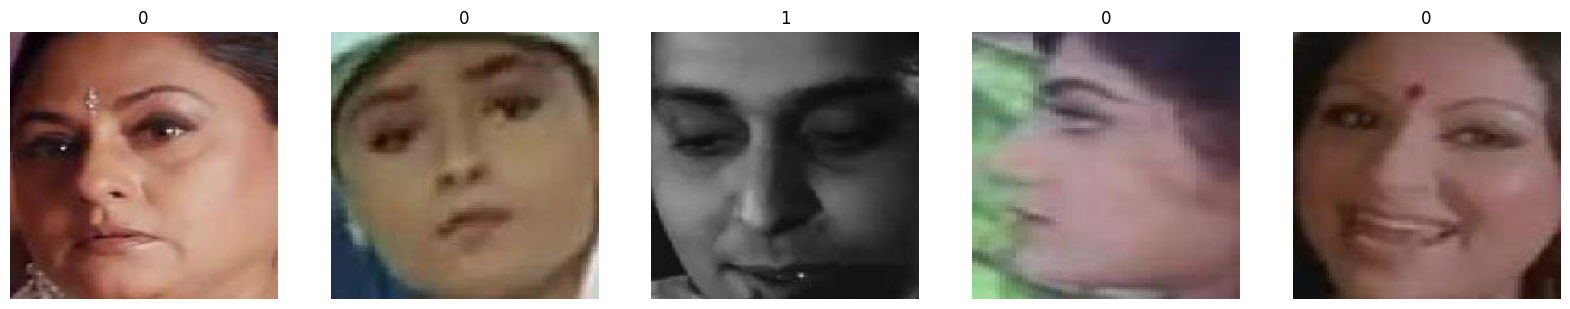

In [17]:
# visualizing images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X[i*40])
    ax[i].set_title(y[i*40])
    ax[i].axis('off')

## 2. Pre-processing the data

In [18]:
# converting 3 dimensional image to 1 dimensional image
X = X.reshape(X.shape[0], 224*224*3)
X.shape

(3000, 150528)

## 3. Creating training and validation set

In [24]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.25, random_state=SEED)

In [25]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((2250, 150528), (2250,)), ((750, 150528), (750,)))

## 4. Defining the MLP model architecture

In [44]:
# Open a strategy scope
with strategy.scope():
    # defining the architecture of the model
    model=Sequential()
    model.add(InputLayer(shape=(X_train.shape[1], )))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(units=1, activation='sigmoid'))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [45]:
# summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 100)            │    15,052,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,058,001 (57.44 MB)

 Trainable params: 15,058,001 (57.44 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Compiling the model

In [46]:
with strategy.scope():
    # compiling the model
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [47]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Please make sure GPU acceleration is enabled in Colab.")


Default GPU Device: /device:GPU:0


2024-09-14 18:53:57.076953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 22455 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-09-14 18:53:57.077579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 22455 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6
2024-09-14 18:53:57.083156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 22455 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-09-14 18:53:57.083777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 22455 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6


## 6. Training the model

In [ ]:
# training the model
model_history = model.fit(X_train, y_train, epochs=25, batch_size=128,validation_data=(X_valid,y_valid))

## 7. Evaluating model performance

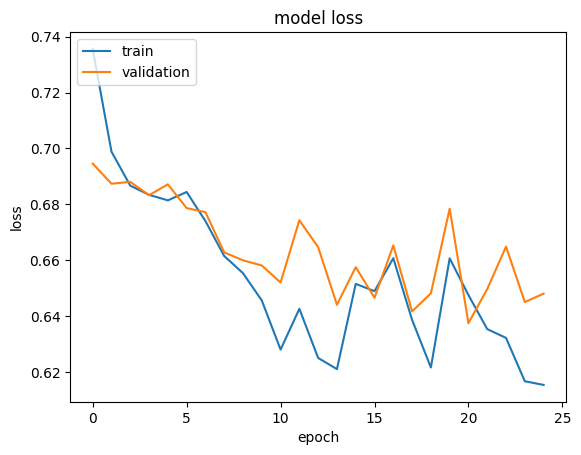

In [49]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

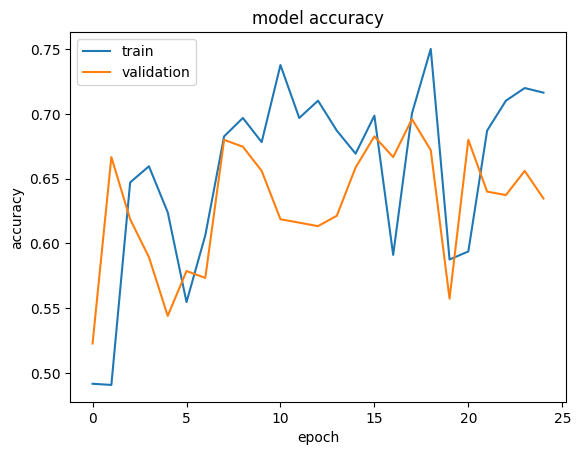

In [50]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# getting predictions in the form of class
predictions = []
for img_name in tqdm_notebook(submission.image_names):
    img = plt.imread('../input/images/' + img_name)
    img = img/255.0
    img = img.reshape(1, 224*224*3)
    predictions.append(model.predict(img))

In [37]:
predictions = [1 if pred[0][0] > .5 else 0 for pred in predictions]

In [38]:
submission["class"] = predictions
submission.head()

,image_names,class
0,5603.jpg,1
1,1286.jpg,1
2,9815.jpg,0
3,8865.jpg,1
4,9306.jpg,0


In [40]:
submission.to_csv("results/submission_MLP_2.csv", index=False)

## 8. Improving the MLP model

* Early Stopping
* Dropout Layer
* BatchNormalization Layer
* Gradient Clipping
* Model Checkpoints

In [63]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout

with strategy.scope():
    # defining the architecture of the model
    model=Sequential()
    model.add(InputLayer(shape=(X_train.shape[1], )))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dropout(rate=0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='sigmoid'))

    # Setting up optimizer and gradient clipping
    adam = Adam(learning_rate=1e-5, clipvalue=1)

    # Setting up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=6, mode='min')

    # compiling the model
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 100)            │    15,052,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,058,201 (57.44 MB)

 Trainable params: 15,058,101 (57.44 MB)

 Non-trainable params: 100 (400.00 B)

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Please make sure GPU acceleration is enabled in Colab.")


In [ ]:
# training the model
model_history = model.fit(X_train, y_train, epochs=25, batch_size=128,validation_data=(X_valid,y_valid))

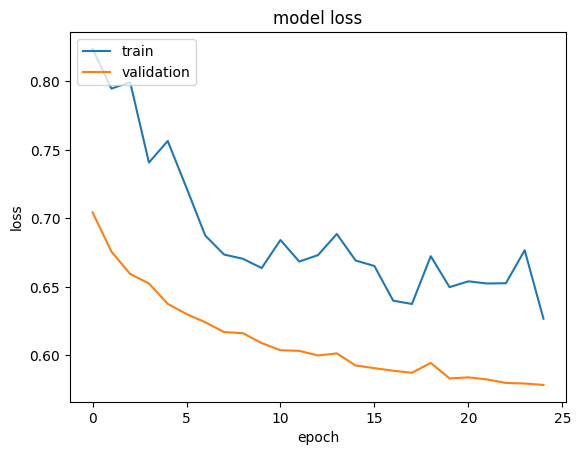

In [67]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

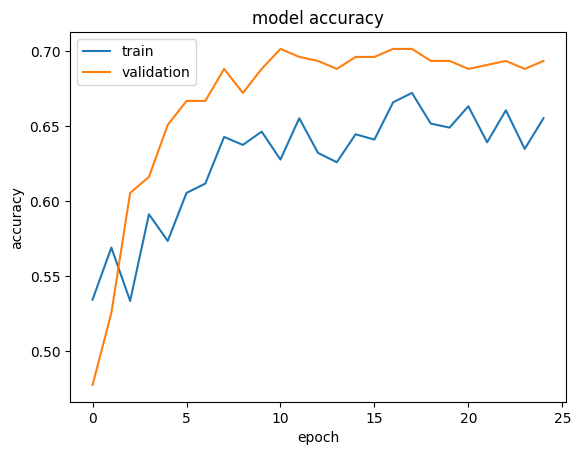

In [68]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

> Our best model is not at the last epoch, so let us implement model checkpoint to save our best model

In [71]:
# defining model checkpointing
from keras.callbacks import ModelCheckpoint

# defining the path to store the weights
filepath="../models/best_weights.keras"

# defining the model checkpointing and metric to monitor
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# defining checkpointing variable
callbacks_list = [checkpoint]

In [97]:
from keras.layers import BatchNormalization, Dropout

with strategy.scope():
    # defining the architecture of the model
    model=Sequential()
    model.add(InputLayer(shape=(X_train.shape[1], )))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dropout(rate=0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='sigmoid'))

In [98]:
# compiling the model
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [99]:
# training the model
model_history = model.fit(X_train, y_train, epochs=25, batch_size=128,validation_data=(X_valid,y_valid), callbacks=callbacks_list)

Epoch 1/25
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5072 - loss: 0.8619
Epoch 1: val_accuracy did not improve from 0.70133
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5082 - loss: 0.8605 - val_accuracy: 0.5307 - val_loss: 0.6780
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5331 - loss: 0.8266
Epoch 2: val_accuracy did not improve from 0.70133
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5338 - loss: 0.8258 - val_accuracy: 0.5973 - val_loss: 0.6641
Epoch 3/25
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5536 - loss: 0.7633
Epoch 3: val_accuracy did not improve from 0.70133
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5549 - loss: 0.7629 - val_accuracy: 0.6907 - val_loss: 0.6499
Epoch 4/25
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5698 - loss: 0.7

In [100]:
predictions = model.predict(X_valid)
predictions = predictions.reshape(750,)

# converting probabilities to classes
prediction_int = predictions >= 0.5
prediction_int = prediction_int.astype(np.int64)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [101]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, prediction_int), '%')

Accuracy on validation set: 0.724 %


In [102]:
# loading the best model
model.load_weights("../models/best_weights.keras")

In [103]:
prediction = model.predict(X_valid)
prediction = prediction.reshape(750,)

# converting probabilities to classes
prediction_int = prediction >= 0.5
prediction_int = prediction_int.astype(np.int64)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [104]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, prediction_int), '%')

Accuracy on validation set: 0.724 %


In [ ]:
# getting predictions in the form of class
predictions = []
for img_name in tqdm_notebook(submission.image_names):
    img = plt.imread('input/images/' + img_name)
    img = img/255.0
    img = img.reshape(1, 224*224*3)
    predictions.append(model.predict(img))

In [37]:
predictions = [1 if pred[0][0] > .5 else 0 for pred in predictions]

In [38]:
submission["class"] = predictions
submission.head()

,image_names,class
0,5603.jpg,1
1,1286.jpg,1
2,9815.jpg,0
3,8865.jpg,1
4,9306.jpg,0


In [39]:
submission.to_csv("results/submission_MLP_Improved.csv", index=False)

## 9. Defining the CNN model architecture

In [19]:
# Import important libraries for the CNN model
from keras.layers import Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, LeakyReLU

In [20]:
# Reading data again without reshaping
X = []

for img_name in tqdm_notebook(train_sample.image_names):
    img = plt.imread('../input/images/' + img_name)
    img = img/255.0
    X.append(img)

X=np.array(X)

y = train_sample["class"].values

  0%|          | 0/3000 [00:00<?, ?it/s]

In [21]:
X.shape

(3000, 224, 224, 3)

In [25]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.25, random_state=SEED)

In [26]:
with strategy.scope():
    # Defining the model architecture
    model = Sequential()
    model.add(InputLayer(shape=(224, 224, 3)))
    model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
    model.add(Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(units=100, activation='sigmoid'))
    model.add(Dense(units=1, activation='sigmoid'))

    # compiling the model
    model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 25)   │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 216, 216, 50)   │        31,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2332800)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │   233,280,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,313,401 (890.02 MB)

 Trainable params: 233,313,401 (890.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_history = model.fit(X_train, y_train, epochs=10, batch_size=128,validation_data=(X_valid,y_valid))

In [30]:
print('Accuracy on train set:', accuracy_score(y_train, model.predict(X_train).astype('int')), '%')

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy on train set: 0.48533333333333334 %


In [32]:
print('Accuracy on validation set:', accuracy_score(y_valid, model.predict(X_valid).astype('int')), '%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy on validation set: 0.504 %


In [ ]:
# getting predictions in the form of class
predictions = []
for img_name in tqdm_notebook(submission.image_names):
    img = plt.imread('../input/images/' + img_name)
    img = img/255.0
    img = img.reshape(1, 224*224*3)
    predictions.append(model.predict(img))

In [ ]:
predictions = [1 if pred[0][0] > .5 else 0 for pred in predictions]

In [ ]:
submission["class"] = predictions
submission.head()

In [ ]:
submission.to_csv("../results/submission_CNN_1.csv", index=False)

## 10. Fine tuning the CNN model

In [33]:
# defining model checkpointing
from keras.callbacks import ModelCheckpoint

# defining the path to store the weights
filepath="../models/best_weights.keras"

# defining the model checkpointing and metric to monitor
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# defining checkpointing variable
callbacks_list = [checkpoint]

In [34]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

with strategy.scope(): 
    # Input layer
    inputs = Input(shape=(224, 224, 3))

    # Convolutional layers
    x = Conv2D(32, (7, 7), activation='relu', strides=(1, 1), padding='valid', name="conv1")(inputs)
    x = LeakyReLU(name='lrelu1')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (4, 4), activation='relu', strides=(1, 1), padding='valid', name="conv2")(x)
    x = LeakyReLU(name='lrelu2')(x)
    x = MaxPooling2D(pool_size=(3, 3), padding='valid', name='pool2')(x)
    
    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(units=100, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.6)(x)
    x = Dense(units=50, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.6)(x)
    
    # Output layer
    outputs = Dense(units=1, activation='sigmoid', name='preds')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [35]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 218, 218, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu1 (LeakyReLU)              │ (None, 218, 218, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 106, 106, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu2 (LeakyReLU)              │ (None, 106, 106, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     3,920,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,946,953 (15.06 MB)

 Trainable params: 3,946,653 (15.06 MB)

 Non-trainable params: 300 (1.17 KB)

In [36]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2250, 224, 224, 3), (2250,), (750, 224, 224, 3), (750,))

In [ ]:
model_history = model.fit(X_train, y_train, epochs=20, batch_size=16,validation_data=(X_valid,y_valid), callbacks=callbacks_list)

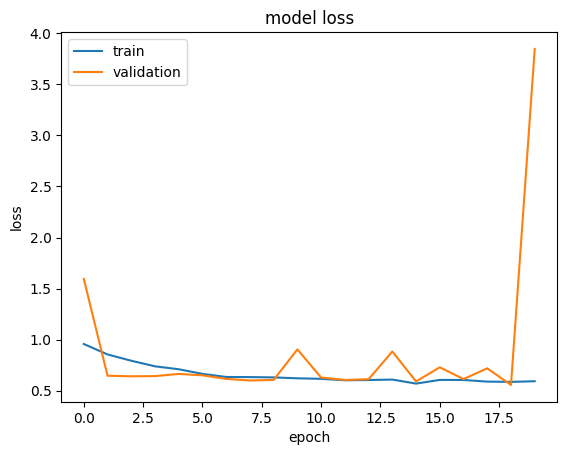

In [38]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

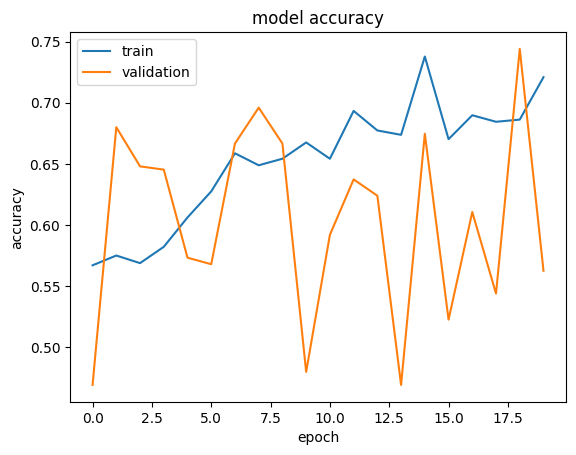

In [39]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
predictions = model.predict(X_valid)
predictions = predictions.reshape(750,)

# converting probabilities to classes
prediction_int = predictions >= 0.5
prediction_int = prediction_int.astype(np.int64)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [46]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, prediction_int), '%')

Accuracy on validation set: 0.5506666666666666 %


In [47]:
# loading the best model
model.load_weights("../models/best_weights.keras")

In [48]:
prediction = model.predict(X_valid)
prediction = prediction.reshape(750,)

# converting probabilities to classes
prediction_int = prediction >= 0.5
prediction_int = prediction_int.astype(np.int64)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [49]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, prediction_int), '%')

Accuracy on validation set: 0.7466666666666667 %


In [ ]:
# getting predictions in the form of class
predictions = []
for img_name in tqdm_notebook(submission.image_names):
    img = plt.imread('../input/images/' + img_name)
    img = img/255.0
    # print(img.shape)
    img = img.reshape(1, 224, 224, 3)
    predictions.append(model.predict(img))

In [ ]:
predictions[0]

array([[0.5798325]], dtype=float32)

In [ ]:
predictions = [1 if pred[0][0] > .5 else 0 for pred in predictions]

In [ ]:
submission["class"] = predictions
submission.head()

,image_names,class
0,5603.jpg,1
1,1286.jpg,1
2,9815.jpg,0
3,8865.jpg,0
4,9306.jpg,0


In [ ]:
submission.to_csv("../results/submission_CNN_Tuned_1.csv", index=False)

## 11. Visualizing CNN Model

1. Visualize Filters and Weights
2. Extract Output of Intermediate Neurons/Layers
3. Locate Important parts of Image

### 1. Visualize Filters and Weights

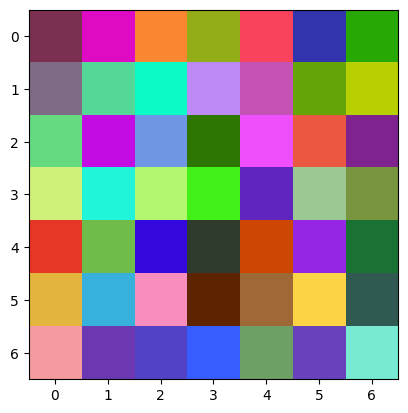

In [50]:
temp = model.get_layer('conv1').get_weights()[0][:, :, :, 0]
temp -= temp.min()
temp /= temp.max()
plt.imshow(temp)
plt.show()

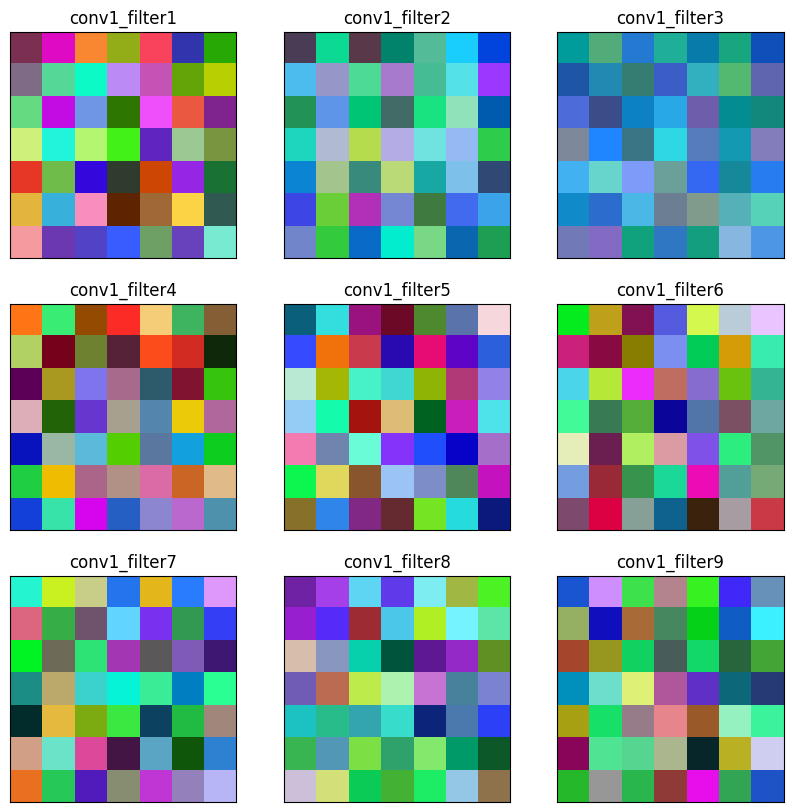

In [51]:
#plot the filters
fig,ax = plt.subplots(nrows=3,ncols=3, figsize=(10, 10))

filter_no = 1
for i in range(3):
    for j in range(3):
        temp = model.get_layer('conv1').get_weights()[0][:, :, :, filter_no - 1]
        temp -= temp.min()
        temp /= temp.max()
        ax[i][j].imshow(temp)
        ax[i][j].set_title('conv1' + '_filter' + str(filter_no))
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        filter_no += 1

### 2. Extract Output of Intermediate Neurons/Layers

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


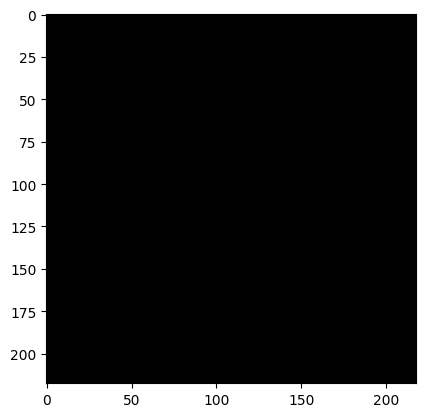

In [54]:
from keras.models import Model


eg_image_idx = 5 #for example
image = X_train[eg_image_idx]

image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('conv1').output)
intermediate_output = intermediate_layer_model.predict(image)[0, :, :, 0]

plt.imshow(intermediate_output, cmap='gray')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


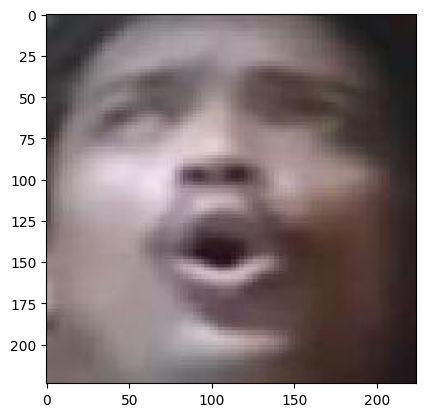

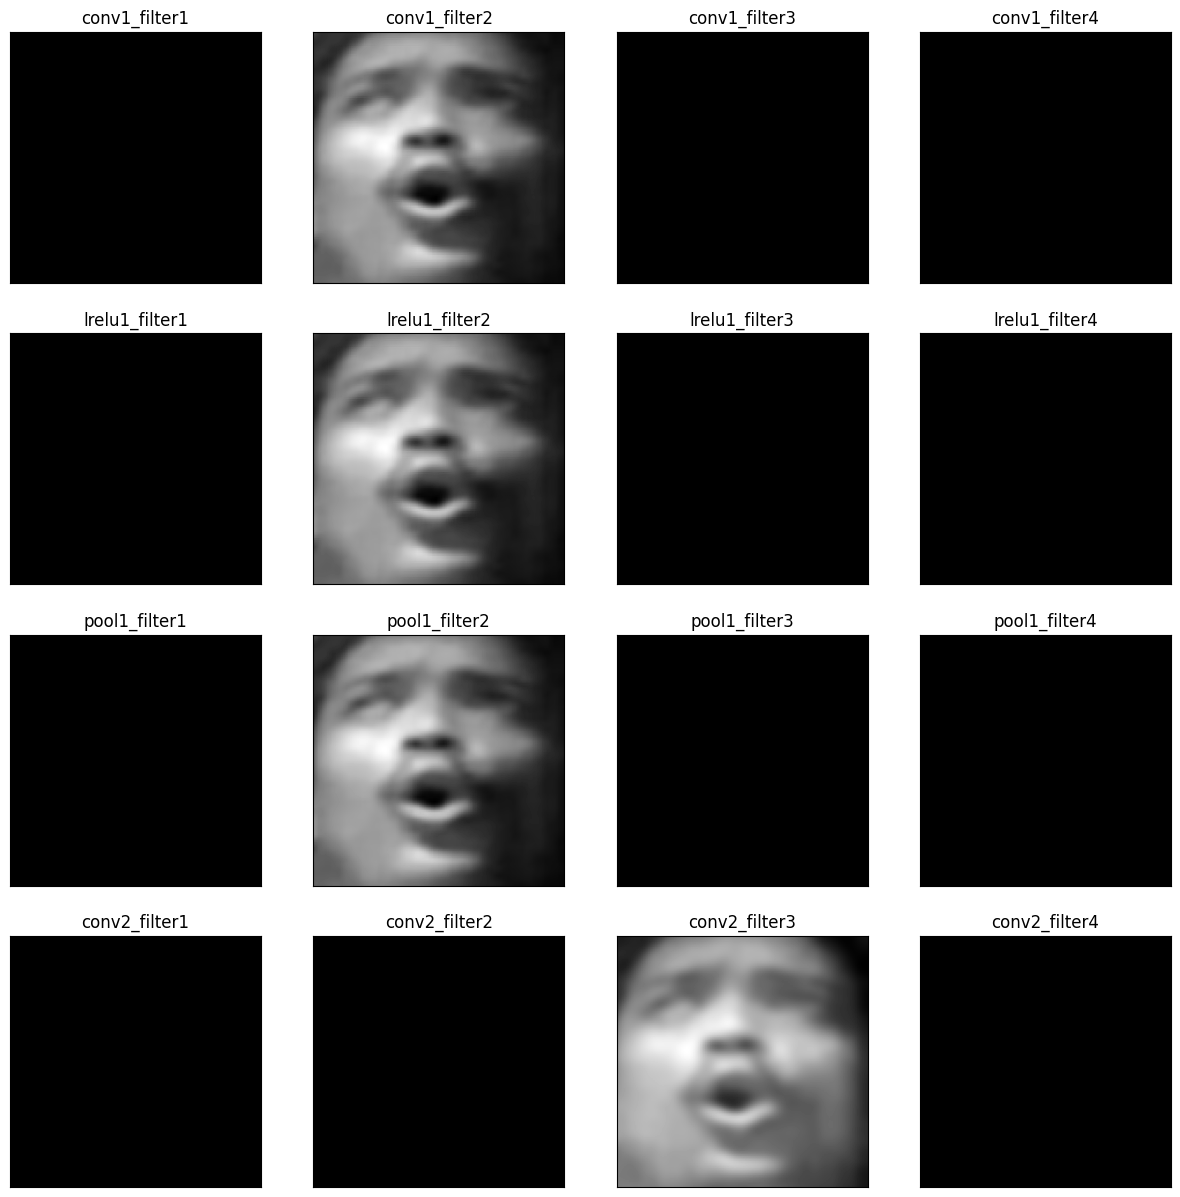

In [55]:
layer_names = ['conv1','lrelu1','pool1', 'conv2']
outputs = []

eg_image_idx = 5 #for example
image = X_train[eg_image_idx]

plt.imshow(image)

image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

#extracting the output and appending to outputs
for layer_name in layer_names:
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(image)
    outputs.append(intermediate_output)

#plotting the outputs
fig,ax = plt.subplots(nrows=len(outputs),ncols=4,figsize=(15,15))

for i in range(len(outputs)):
    for z in range(4):
        ax[i][z].imshow(outputs[i][0,:,:,z], cmap='gray')
        ax[i][z].set_title(layer_names[i] + '_filter' + str(z + 1))
        ax[i][z].set_xticks([])
        ax[i][z].set_yticks([])
plt.show()

### 3. Locate Important parts of Image

Creating heatmap


2024-09-14 20:27:39.824276: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


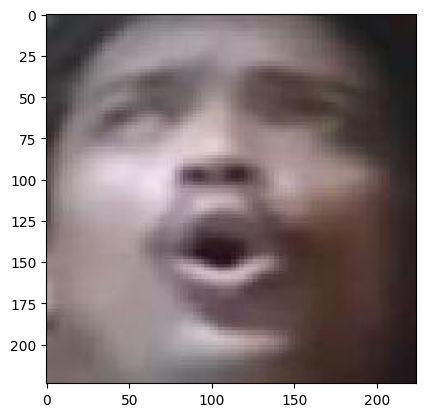

[None]

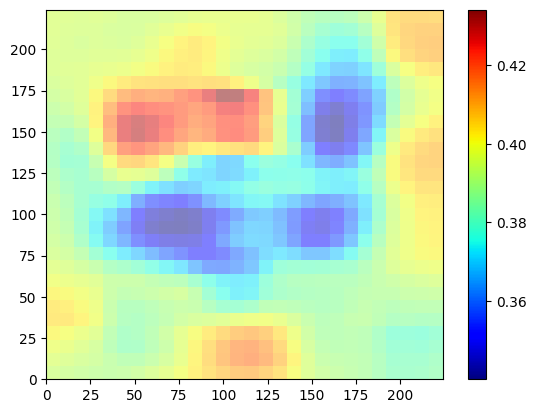

In [58]:
def iter_occlusion(image, size=4):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

   occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
   occlusion_center = np.full((size, size, 1), [0.5], np.float32)
   occlusion_padding = size * 2

   # print('padding...')
   image_padded = np.pad(image, ( \
   (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
   ), 'constant', constant_values = 0.0)

   for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

       for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
           tmp = image_padded.copy()

           tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

           tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

           yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

# take example image
image = X_train[eg_image_idx]
correct_class = np.argmax(y_train[eg_image_idx])

# define variables to use
img_size = image.shape[0]
occlusion_size = 8
heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)


print('Creating heatmap')
for n, (x, y, img_float) in enumerate(iter_occlusion(image, size=occlusion_size)):

    X = img_float.reshape(1, 224, 224, 3)
    out = model.predict(X, verbose=0)

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

plt.imshow(image)

plt.show()


plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.50)
plt.colorbar().solids.set(alpha=1)


## 12. Gender Classification Through Transfer Learning

1. Transfer Learning with Feature Extraction
2. Transfer Learning with Architecture
3. Transfer Learning with Frozen Layers

### 1. Transfer Learning with Feature Extraction

In [14]:
from keras.models import Model
from keras.utils import to_categorical
#used to preprocess data according to VGG16
from keras.applications.vgg16 import preprocess_input
#for instantiating the model and loading the weights and biases
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, InputLayer

In [15]:
# load images and store it in numpy array
X = []
for img_name in tqdm_notebook(train_sample.image_names):
    img = plt.imread('../input/images/' + img_name)
    # img = img/255.0
    X.append(img)

X=np.array(X)

# storing the target variable in separate variable
y = train_sample["class"].values

  0%|          | 0/3000 [00:00<?, ?it/s]

In [16]:
print(y)
y = to_categorical(y)
print(y)

[0 1 1 ... 0 0 1]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [17]:
X.min(), X.max(), X.shape

(0, 255, (3000, 224, 224, 3))

In [18]:
X = preprocess_input(X, data_format='channels_last')

In [19]:
X.min(), X.max(), X.shape

(-123.68, 151.061, (3000, 224, 224, 3))

In [20]:
# splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [21]:
X_train.shape

(2100, 224, 224, 3)

> ### Load weights of pretrained model

In [22]:
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

In [23]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# creating a VGG16 model with imagenet pretrained weights , accepting input of shape (224,224,3)
# also remove the final layers from model(include_top= False)
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [25]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

> ### Fine tune the model for the current problem

1. Extract features
2. Flatten the data
3. Rescale features
4. Create a Neural Network Model
5. Compile the model
6. Train and Validate the model

In [26]:
# extract features using the pretrained VGG16 model
# for training set
base_model_pred = base_model.predict(X_train)
#for validation set
base_model_pred_valid = base_model.predict(X_valid)

I0000 00:00:1726346240.680381  311548 service.cc:146] XLA service 0x757ef8106a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726346240.680591  311548 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1726346240.680600  311548 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-14 20:37:20.708259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-14 20:37:20.821888: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 5/66 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step

I0000 00:00:1726346246.145880  311548 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


In [27]:
#show shape of predictions
base_model_pred.shape

(2100, 7, 7, 512)

In [28]:
# flattening the model output to one dimension for every sample of training set
base_model_pred = base_model_pred.reshape(2100, 7*7*512)

In [29]:
base_model_pred.shape

(2100, 25088)

In [30]:
base_model_pred_valid.shape

(900, 7, 7, 512)

In [31]:
# flattening the model output to one dimension for every sample of validation set
base_model_pred_valid = base_model_pred_valid.reshape(900, 7*7*512)

In [32]:
base_model_pred_valid.shape

(900, 25088)

In [33]:
# checking the min and max of the extracted features
base_model_pred.min(), base_model_pred.max()

(0.0, 265.69174)

In [34]:
#get maximum value from generated features
max_val = base_model_pred.max()

In [35]:
#normalizing features generated from the VGG16 model to [0,1]
base_model_pred = base_model_pred / max_val
base_model_pred_valid = base_model_pred_valid / max_val
base_model_pred.min(), base_model_pred.max()

(0.0, 1.0)

In [40]:
with strategy.scope():    
    #create a sequential model
    model = Sequential()
    # add input layer to the model that accepts input of shape 7*7*512
    model.add(InputLayer((7*7*512, )))
    # add fully connected layer with 1024 neurons and relu activation
    model.add(Dense(units=1024, activation='relu'))
    # add fully connected layer with 2 neurons and relu activation
    model.add(Dense(units=2, activation='softmax'))

In [41]:
from keras.callbacks import ModelCheckpoint

with strategy.scope():
    # defining the path to store the weights
    filepath="../models/best_weights.keras"

    # defining the model checkpointing and metric to monitor
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # defining checkpointing variable
    callbacks_list = [checkpoint]

    # compile the model
    model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')

In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,693,186 (98.01 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model using features generated from VGG16 model
model.fit(base_model_pred, y_train, epochs=100, validation_data=(base_model_pred_valid, y_valid), callbacks=callbacks_list)

In [44]:
# get predictions
predictions = model.predict(base_model_pred_valid)
#show predictions
predictions = np.argmax(predictions, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [45]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(np.argmax(y_valid, axis=1), predictions), '%')

Accuracy on validation set: 0.8233333333333334 %


In [46]:
# loading the best model
model.load_weights("../models/best_weights.keras")

In [47]:
# get predictions
predictions = model.predict(base_model_pred_valid)
#show predictions
predictions = np.argmax(predictions, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [48]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(np.argmax(y_valid, axis=1), predictions), '%')

Accuracy on validation set: 0.8322222222222222 %


In [ ]:
# getting predictions in the form of class
predictions = []
for img_name in tqdm_notebook(submission.image_names):
    img = np.array([plt.imread('../input/images/' + img_name)])
    img = preprocess_input(img)
    img = base_model.predict(img)
    img = img.reshape(1, 7*7*512)
    # print(np.argmax(model.predict(img), axis=1))
    # break
    predictions.append(np.argmax(model.predict(img), axis=1))

In [ ]:
predictions[0]

array([1])

In [ ]:
predictions = [pred[0] for pred in predictions]

In [ ]:
submission["class"] = predictions
submission.head()

,image_names,class
0,5603.jpg,1
1,1286.jpg,1
2,9815.jpg,0
3,8865.jpg,1
4,9306.jpg,1


In [ ]:
submission.to_csv("../results/submission_transfer_1.csv", index=False)

### 2. Transfer Learning with Architecture

In [55]:
base_model.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_23>

In [61]:
# creating our own model
from keras.models import Model

with strategy.scope():
    x = Flatten()(base_model.layers[-4].output)
    x = Dense(100, activation='relu', name='fc1')(base_model.layers[-4].output)
    y = Dense(2, activation='softmax', name='prediction')(x)
    my_model = Model(inputs=base_model.input, outputs=y)
    
    # compile the model
    my_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

my_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,223,790 (65.70 MB)

 Trainable params: 17,223,790 (65.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training the model
my_model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid))

In [ ]:
# get predictions
predictions = my_model.predict(base_model_pred_valid)
#show predictions
predictions = np.argmax(predictions, axis=1)

19/19 [==============================] - 0s 3ms/step


In [ ]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(np.argmax(y_valid, axis=1), predictions), '%')

Accuracy on validation set: 0.8316666666666667 %


### 3. Transfer Learning with Frozen Layers - train some layers while freeze others

In [56]:
my_model.layers

In [57]:
# to set the first 15 layers to non-trainable (weights will not be updated)
for layer in my_model.layers[:15]:
    layer.trainable = False

In [58]:
with strategy.scope():
    # compile the model
    my_model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')

In [59]:
# training the model
my_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
40/40 [==============================] - 10s 223ms/step - loss: 0.2141 - accuracy: 0.9111 - val_loss: 0.7144 - val_accuracy: 0.7667
Epoch 2/10
40/40 [==============================] - 8s 190ms/step - loss: 0.2012 - accuracy: 0.9246 - val_loss: 0.7944 - val_accuracy: 0.7537
Epoch 3/10
40/40 [==============================] - 8s 203ms/step - loss: 0.1582 - accuracy: 0.9421 - val_loss: 0.8598 - val_accuracy: 0.7722
Epoch 4/10
40/40 [==============================] - 8s 209ms/step - loss: 0.1485 - accuracy: 0.9357 - val_loss: 0.9340 - val_accuracy: 0.7778
Epoch 5/10
40/40 [==============================] - 8s 191ms/step - loss: 0.1343 - accuracy: 0.9444 - val_loss: 0.9506 - val_accuracy: 0.7648
Epoch 6/10
40/40 [==============================] - 8s 207ms/step - loss: 0.1172 - accuracy: 0.9524 - val_loss: 1.0042 - val_accuracy: 0.7815
Epoch 7/10
40/40 [==============================] - 8s 190ms/step - loss: 0.1076 - accuracy: 0.9611 - val_loss: 1.1384 - val_accuracy: 0.7852
Epoch

In [ ]:
# get predictions
predictions = my_model.predict(base_model_pred_valid)
#show predictions
predictions = np.argmax(predictions, axis=1)

19/19 [==============================] - 0s 3ms/step


In [ ]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(np.argmax(y_valid, axis=1), predictions), '%')

Accuracy on validation set: 0.8316666666666667 %
